In [99]:
from io import open

import glob

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os

import random

import string

import time

import torch
import torch.nn as nn

import unicodedata

In [100]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [101]:
all_letters = string.ascii_letters + " .,;'"

In [102]:
n_letters = len(all_letters)

In [103]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [104]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [105]:
print(category_lines['Italian'][300:306])

["D'onofrio", 'Drago', 'Durante', 'Elena', 'Episcopo', 'Ermacora']


In [106]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [107]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [108]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [109]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [110]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [111]:
n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

In [112]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Bakhanoff
category = Chinese / line = Feng
category = Italian / line = Airaldi
category = German / line = Vonnegut
category = Italian / line = Manfredi
category = Arabic / line = Hadad
category = Czech / line = Klineberg
category = Polish / line = Broz
category = Arabic / line = Sayegh
category = Vietnamese / line = Dam


In [113]:
criterion = nn.NLLLoss()

In [114]:
def train(category_tensor, line_tensor):
    hidden = gru.initHidden()
    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i].unsqueeze(0), hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [115]:
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 16s) 2.9947 Overfield / Dutch ✗ (English)
10000 10% (0m 35s) 2.8138 Cormac / Czech ✗ (Irish)
15000 15% (0m 52s) 2.8955 Bishara / Japanese ✗ (Arabic)
20000 20% (1m 9s) 1.0756 Egonidis / Greek ✓
25000 25% (1m 25s) 2.9115 White / French ✗ (Scottish)
30000 30% (1m 42s) 1.4859 Sauber / German ✓
35000 35% (1m 59s) 1.4260 Escarcega / Spanish ✓
40000 40% (2m 16s) 1.0170 Roggeveen / Dutch ✓
45000 45% (2m 32s) 5.3260 De laurentis / Greek ✗ (Italian)
50000 50% (2m 48s) 2.1385 Tejc / German ✗ (Czech)
55000 55% (3m 4s) 5.3059 Gavril / Irish ✗ (Greek)
60000 60% (3m 22s) 2.1711 Grulich / Irish ✗ (Czech)
65000 65% (3m 40s) 1.0397 Yep / Korean ✗ (Chinese)
70000 70% (3m 57s) 0.3959 Opova / Czech ✓
75000 75% (4m 14s) 4.8755 Oorschot / Scottish ✗ (Dutch)
80000 80% (4m 31s) 2.0150 Buggenum / English ✗ (Dutch)
85000 85% (4m 48s) 2.1976 Jeong / German ✗ (Korean)
90000 90% (5m 5s) 1.6136 Bolivar / Czech ✗ (Spanish)
95000 95% (5m 22s) 0.0320 Benedetti / Italian ✓
100000 100% (5m 39s) 1.9568 Black /

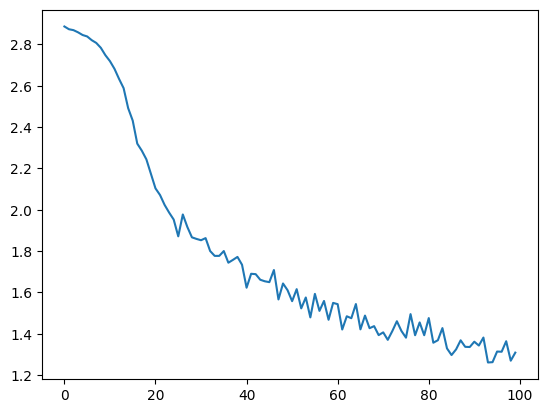

In [116]:
plt.figure()
plt.plot(all_losses)

In [117]:
def evaluate(line_tensor):
    hidden = gru.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i].unsqueeze(0), hidden)

    return output


C:\Users\layor\AppData\Local\Temp\ipykernel_9588\1588391092.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\layor\AppData\Local\Temp\ipykernel_9588\1588391092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


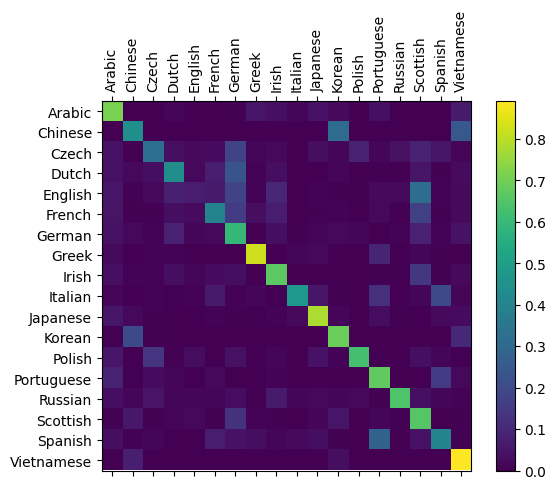

In [118]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [119]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [120]:
predict('Zamek')
predict('Jackson')
predict('Satoshi')


> Zamek
(-0.89) Czech
(-1.19) Polish
(-1.82) Dutch

> Jackson
(-0.23) Scottish
(-2.44) English
(-3.37) German

> Satoshi
(-0.71) Arabic
(-0.75) Japanese
(-4.41) Polish


In [121]:
predict("Ayanami")
predict("Kowalski")
predict("Dostoevsky")


> Ayanami
(-0.23) Japanese
(-2.09) Arabic
(-2.82) Italian

> Kowalski
(-0.05) Polish
(-3.87) Czech
(-4.30) Russian

> Dostoevsky
(-0.77) Russian
(-1.16) Czech
(-2.03) Polish
